In [63]:
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import optuna


warnings.filterwarnings('ignore')

In [2]:
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [3]:
import config

In [102]:
test = pd.read_csv(config.TEST_FILE)
train = pd.read_csv(config.TRAINING_FILE)
contact = pd.read_csv(config.CONTACT_FILE)

In [103]:
train.head()

,cellid,phase,order_within_phase,order
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0


In [104]:
train["order"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43])

In [105]:
train["order_within_phase"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [106]:
test.head()

,cellid,phase,order_within_phase,order
0,SCG0089_CTTATGTTCCCGCCTA-1,NaN,NaN,NaN
1,SCG0093_AGAACCGCACAGCCAT-1,NaN,NaN,NaN
2,SCG0090_CCAGGATGTGCTCACC-1,NaN,NaN,NaN
3,SCG0089_TACCTTTAGCACTTGG-1,NaN,NaN,NaN
4,SCG0092_TGATCAGGTTTGAGGC-1,NaN,NaN,NaN


In [107]:
contact.head()

,chr1,start1,end1,chr2,start2,end2,cellid
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1


In [108]:
print(contact.shape)
total_contacts = contact.shape[0]

(5679074, 7)


## Feature Engineering

In [109]:
contact.head()

,chr1,start1,end1,chr2,start2,end2,cellid
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1


In [110]:
contact["is_m_chr1"] = contact["chr1"].str.endswith("M").astype(int)
contact["is_m_chr2"] = contact["chr2"].str.endswith("M").astype(int)

contact["length1"] = contact["end1"] - contact["start1"]
contact["length2"] = contact["end2"] - contact["start2"]

chr1_chr2_contacts = contact.groupby(
    "chr1")["chr2"].size().rename("chr1_chr2_count")
chr2_chr1_contacts = contact.groupby(
    "chr2")["chr1"].size().rename("chr2_chr1_count")
contact = contact.merge(chr1_chr2_contacts, on="chr1", how="left")
contact = contact.merge(chr2_chr1_contacts, on="chr2", how="left")

contact["start_distance"] = contact["start1"] - contact["start2"]
contact["end_distance"] = contact["end1"] - contact["end2"]
contact["abs_start_distance"] = contact["start_distance"].abs()
contact["abs_end_distance"] = contact["end_distance"].abs()

contact["length_ratio"] = contact["length1"] / (contact["length2"] + 1e-5)

contact["intra_contact"] = (contact["chr1"] == contact["chr2"]).astype(int)
contact["inter_contact"] = (contact["chr1"] != contact["chr2"]).astype(int)

agg_features = contact.groupby("cellid").agg(
    total_contacts=("chr1", "count"),
    median_start_distance=("start_distance", "median"),
    median_end_distance=("end_distance", "median"),
    min_start_distance=("start_distance", "min"),
    min_end_distance=("end_distance", "min"),
    max_start_distance=("start_distance", "max"),
    max_end_distance=("end_distance", "max"),
    std_start_distance=("start_distance", "std"),
    std_end_distance=("end_distance", "std"),
    median_abs_start_distance=("abs_start_distance", "median"),
    median_abs_end_distance=("abs_end_distance", "median"),
    median_length1=("length1", "median"),
    median_length2=("length2", "median"),
    mean_length1=("length1", "mean"),
    mean_length2=("length2", "mean"),
    sum_is_m_chr1=("is_m_chr1", "sum"),
    sum_is_m_chr2=("is_m_chr2", "sum"),
    mean_chr1_chr2_count=("chr1_chr2_count", "mean"),
    std_chr1_chr2_count=("chr1_chr2_count", "std"),
    mean_chr2_chr1_count=("chr2_chr1_count", "mean"),
    std_chr2_chr1_count=("chr2_chr1_count", "std"),
    intra_contacts=("intra_contact", "sum"),
    inter_contacts=("inter_contact", "sum"),
    median_length_ratio=("length_ratio", "median"),
    mean_length_ratio=("length_ratio", "mean")
).fillna(0)

agg_features["ratio_intra"] = agg_features["intra_contacts"] / \
    agg_features["total_contacts"]
agg_features["ratio_inter"] = agg_features["inter_contacts"] / \
    agg_features["total_contacts"]
agg_features["ratio_m_chr1"] = agg_features["sum_is_m_chr1"] / \
    agg_features["total_contacts"]
agg_features["ratio_m_chr2"] = agg_features["sum_is_m_chr2"] / \
    agg_features["total_contacts"]

train = train.merge(agg_features, on="cellid", how="left")
test = test.merge(agg_features, on="cellid", how="left")

In [111]:
train.head()

,cellid,phase,order_within_phase,order,total_contacts,median_start_distance,median_end_distance,min_start_distance,min_end_distance,max_start_distance,...,mean_chr2_chr1_count,std_chr2_chr1_count,intra_contacts,inter_contacts,median_length_ratio,mean_length_ratio,ratio_intra,ratio_inter,ratio_m_chr1,ratio_m_chr2
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0,2544,-3083.5,-3136.0,-157735287,-157735390,138895729,...,169921.310142,81955.221815,2272,272,0.840245,1.174423,0.893082,0.106918,0.429245,0.420597
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0,2245,-828.0,-896.0,-145560608,-145560516,162532950,...,167178.631626,68116.136704,1981,264,0.564516,1.153988,0.882405,0.117595,0.452561,0.444098
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0,2038,-1204.0,-1251.0,-148714493,-148714367,162097207,...,164929.056919,70929.047838,1798,240,0.601887,1.197960,0.882237,0.117763,0.484789,0.481845
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0,4164,-2022.0,-2056.0,-162678755,-162678683,183634905,...,163697.983670,69579.426225,3733,431,0.682372,1.135773,0.896494,0.103506,0.515610,0.516090
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0,2451,-980.0,-1006.0,-155115912,-155115912,165218506,...,169955.085679,72591.043953,2086,365,0.659794,1.273627,0.851081,0.148919,0.459404,0.455732


## Model

In [112]:
y = train["phase"]
X = train.drop(["cellid", "phase",
               "order", "order_within_phase"], axis=1)

In [113]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [114]:
print("Encoded y:", y_encoded[:5])
print("X features:", X.columns.tolist())

Encoded y: [0 0 0 0 0]
X features: ['total_contacts', 'median_start_distance', 'median_end_distance', 'min_start_distance', 'min_end_distance', 'max_start_distance', 'max_end_distance', 'std_start_distance', 'std_end_distance', 'median_abs_start_distance', 'median_abs_end_distance', 'median_length1', 'median_length2', 'mean_length1', 'mean_length2', 'sum_is_m_chr1', 'sum_is_m_chr2', 'mean_chr1_chr2_count', 'std_chr1_chr2_count', 'mean_chr2_chr1_count', 'std_chr2_chr1_count', 'intra_contacts', 'inter_contacts', 'median_length_ratio', 'mean_length_ratio', 'ratio_intra', 'ratio_inter', 'ratio_m_chr1', 'ratio_m_chr2']


## Find best hyperparameters with optuna

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42)

## Model evaluation with KFold

In [116]:
train.shape

(1501, 33)

In [117]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1
    }

    scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in cv.split(X, y_encoded):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

        model = XGBClassifier(**params, early_stopping_rounds=50)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)

In [ ]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10, timeout=3600)

[I 2025-02-27 14:26:54,269] A new study created in memory with name: no-name-2557b9f3-2c9c-4c14-9527-2e9dfa49c24a
[I 2025-02-27 14:27:42,595] Trial 0 finished with value: 0.6302458471760797 and parameters: {'booster': 'dart', 'learning_rate': 0.04329683968158647, 'max_depth': 6, 'n_estimators': 719, 'subsample': 0.8306272348137163, 'colsample_bytree': 0.8104909671700431, 'gamma': 0.30436881860270604, 'reg_alpha': 0.6485664350474025, 'reg_lambda': 0.44450814609077693}. Best is trial 0 with value: 0.6302458471760797.
[I 2025-02-27 14:27:58,115] Trial 1 finished with value: 0.6222547065337763 and parameters: {'booster': 'dart', 'learning_rate': 0.25572205050392205, 'max_depth': 5, 'n_estimators': 202, 'subsample': 0.9738350871135497, 'colsample_bytree': 0.8951808483279196, 'gamma': 0.11649774923309153, 'reg_alpha': 0.20941521572473354, 'reg_lambda': 0.15739561327168528}. Best is trial 0 with value: 0.6302458471760797.
[I 2025-02-27 14:28:15,019] Trial 2 finished with value: 0.619581395348

In [128]:
best_params = {'booster': 'dart',
               'learning_rate': 0.06003045121841921,
               'max_depth': 4,
               'n_estimators': 620,
               'subsample': 0.8808977267646029,
               'colsample_bytree': 0.6994151120782637,
               'gamma': 0.29938976579104853,
               'reg_alpha': 0.28087865686560587,
               'reg_lambda': 0.8010940381702771,
               "n-jobs": -1,
               "random_state": 42,
               "objective": "multi:softmax",
               "num_class": 3
               }

In [129]:
print("Best parameters:", best_params)

Best parameters: {'booster': 'dart', 'learning_rate': 0.06003045121841921, 'max_depth': 4, 'n_estimators': 620, 'subsample': 0.8808977267646029, 'colsample_bytree': 0.6994151120782637, 'gamma': 0.29938976579104853, 'reg_alpha': 0.28087865686560587, 'reg_lambda': 0.8010940381702771, 'n-jobs': -1, 'random_state': 42, 'objective': 'multi:softmax', 'num_class': 3}


In [121]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [122]:
accuracy_scores = []

In [123]:
for train_idx, val_idx in folds.split(X, y_encoded):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    model = XGBClassifier(**best_params, early_stopping_rounds=50)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)
    print(f"Fold accuracy: {accuracy:.4f}")

mean_accuracy = np.mean(accuracy_scores)
print(f"\nMean cross-validated accuracy: {mean_accuracy:.4f}")

Fold accuracy: 0.5980
Fold accuracy: 0.6667
Fold accuracy: 0.6267
Fold accuracy: 0.6700
Fold accuracy: 0.6133

Mean cross-validated accuracy: 0.6349


In [125]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)

    plt.figure(figsize=(8, 6))
    plt.barh(range(n_features),
             feature_importances[sorted_idx], align="center")
    plt.yticks(np.arange(n_features), X.columns[sorted_idx])
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances")
    plt.show()

    # Print feature names and their importance
    for idx in sorted_idx:
        print(f"{X.columns[idx]}: {feature_importances[idx]}")

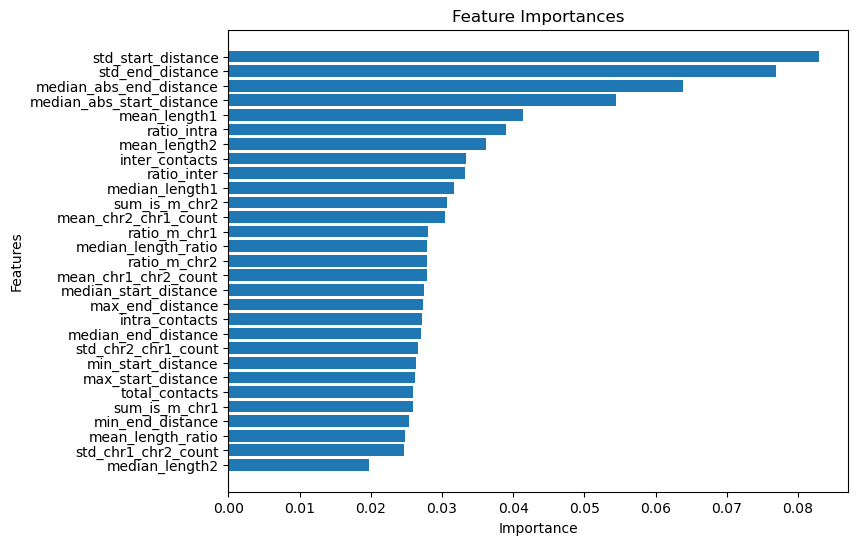

median_length2: 0.019729848951101303
std_chr1_chr2_count: 0.024615494534373283
mean_length_ratio: 0.024791084229946136
min_end_distance: 0.025372756645083427
sum_is_m_chr1: 0.025929566472768784
total_contacts: 0.025953004136681557
max_start_distance: 0.02623458206653595
min_start_distance: 0.026342738419771194
std_chr2_chr1_count: 0.026585835963487625
median_end_distance: 0.027043147012591362
intra_contacts: 0.027213530614972115
max_end_distance: 0.027333715930581093
median_start_distance: 0.027431773021817207
mean_chr1_chr2_count: 0.02783745899796486
ratio_m_chr2: 0.027841836214065552
median_length_ratio: 0.02786300517618656
ratio_m_chr1: 0.027982845902442932
mean_chr2_chr1_count: 0.03039461560547352
sum_is_m_chr2: 0.030683279037475586
median_length1: 0.03164336830377579
ratio_inter: 0.0332067608833313
inter_contacts: 0.033300768584012985
mean_length2: 0.03618422523140907
ratio_intra: 0.03904588893055916
mean_length1: 0.041317425668239594
median_abs_start_distance: 0.05448250472545624

In [126]:
plot_feature_importances(model)